<a href="https://colab.research.google.com/github/Sheepybloke2-0/CSE847-Project/blob/main/Model_Training/tinyml_seedling_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check that imports for the rest of the file work.
import tensorflow as tf

!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q kaggle

!apt-get update && apt-get -qq install xxd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Allow matplotlib images to render immediately.
%matplotlib inline

import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
# from tinymlgen import port

from IPython import display

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
from google.colab import files
import pathlib
kaggleJson = pathlib.Path("/content/.kaggle/kaggle.json")
if not kaggleJson.is_file():
  # files.upload()
  !mkdir -p /content/.kaggle/
  %cd /content/gdrive/My\ Drive/
  !cp ./kaggle.json /content/.kaggle/
  !chmod 600 /content/.kaggle/kaggle.json
%env KAGGLE_CONFIG_DIR=/content/.kaggle
!echo $KAGGLE_CONFIG_DIR
!kaggle config view
!kaggle datasets list

/content/gdrive/My Drive
env: KAGGLE_CONFIG_DIR=/content/.kaggle
/content/.kaggle
Configuration values from /content/.kaggle
- username: reubenlewis
- path: None
- proxy: None
- competition: None
ref                                                       title                                         size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           2700  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    8MB  2021-02-22 08:29:21           1563  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            296  
aagghh/crypto-telegram-groups                             Crypto tele

In [ ]:
# NOTE: Remove the zip file and redownload if the unzip isn't working properly
imageZip = pathlib.Path('/content/gdrive/My Drive/v2-plant-seedlings-dataset.zip')
if not imageZip.is_file():
  !kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset
  !ls
else:
  %cd /content/gdrive/My\ Drive/
!unzip v2-plant-seedlings-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/nonsegmentedv2/Charlock/308.png  
  inflating: /content/nonsegmentedv2/Charlock/309.png  
  inflating: /content/nonsegmentedv2/Charlock/31.png  
  inflating: /content/nonsegmentedv2/Charlock/310.png  
  inflating: /content/nonsegmentedv2/Charlock/311.png  
  inflating: /content/nonsegmentedv2/Charlock/312.png  
  inflating: /content/nonsegmentedv2/Charlock/313.png  
  inflating: /content/nonsegmentedv2/Charlock/314.png  
  inflating: /content/nonsegmentedv2/Charlock/315.png  
  inflating: /content/nonsegmentedv2/Charlock/316.png  
  inflating: /content/nonsegmentedv2/Charlock/317.png  
  inflating: /content/nonsegmentedv2/Charlock/318.png  
  inflating: /content/nonsegmentedv2/Charlock/319.png  
  inflating: /content/nonsegmentedv2/Charlock/32.png  
  inflating: /content/nonsegmentedv2/Charlock/320.png  
  inflating: /content/nonsegmentedv2/Charlock/321.png  
  inflating: /content/nonsegmentedv2/Charlock/322.png  

In [ ]:
rootDir = pathlib.Path('/content/')
%cd /content/
!rm -r sample_data

imageCount = len(list(rootDir.glob('nonsegmentedv2/*/*.png')))
print(imageCount)

/content
5539


In [ ]:
# CONSTANTS GO HERE
BUFFER_SIZE = imageCount
BATCH_SIZE = 128
IM_SIZE = (128, 128)
IM_DIMS = (128, 128,3)
EPOCHS = 20
FULL_MODEL = '/content/gdrive/My Drive/full_model'
LITE_MODEL = '/content/gdrive/My Drive/lite_model.tflite'
LITE_MODEL_ESC = '/content/gdrive/My\ Drive/lite_model.tflite'
MICRO_MODEL = '/content/gdrive/My Drive/micro_model.cc'
MICRO_MODEL_ESC = '/content/gdrive/My\ Drive/micro_model.cc'

In [ ]:
trainPath = os.path.join(rootDir, 'nonsegmentedv2')

trainDataSet = tf.keras.preprocessing.image_dataset_from_directory(
    trainPath,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IM_SIZE,
    batch_size=BATCH_SIZE
)

testDataSet = tf.keras.preprocessing.image_dataset_from_directory(
    trainPath,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IM_SIZE,
    batch_size=BATCH_SIZE
)
classNames = trainDataSet.class_names
print(classNames)

Found 5539 files belonging to 12 classes.
Using 4432 files for training.
Found 5539 files belonging to 12 classes.
Using 1107 files for validation.
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'ShepherdтАЩs Purse', 'Small-flowered Cranesbill', 'Sugar beet']


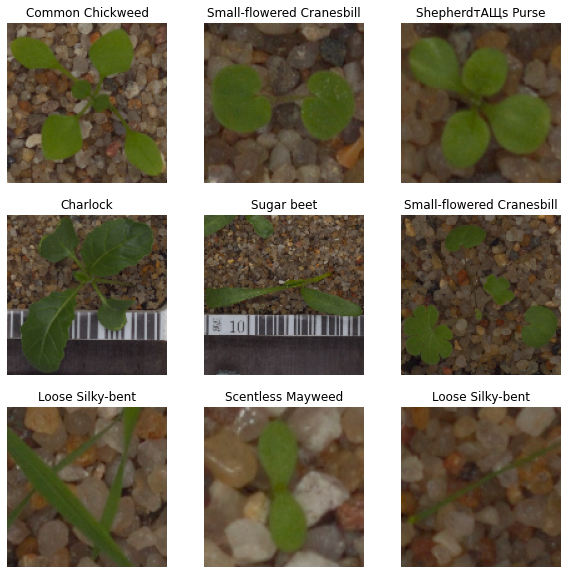

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in trainDataSet.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classNames[labels[i]])
    plt.axis("off")

In [ ]:
def classificationModel(trainImgs, testImgs):
  model = tf.keras.Sequential()
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IM_DIMS),
  model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=IM_DIMS))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(32, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(len(trainImgs.class_names)))

  model.summary()

  model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  return model.fit(trainImgs, validation_data=testImgs, epochs=EPOCHS)

In [ ]:
history = classificationModel(trainDataSet, testDataSet)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/full_model/assets


Text(0.5, 1.0, 'Training/Test Loss')

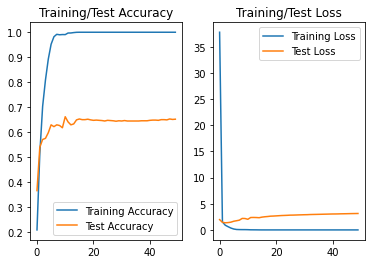

In [ ]:
history.model.save(FULL_MODEL)

acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

loss = history.history['loss']
test_loss = history.history['val_loss']

epochs_rng = range(EPOCHS)

plt.subplot(1,2, 1)
plt.plot(epochs_rng, acc, label='Training Accuracy')
plt.plot(epochs_rng, test_acc, label='Test Accuracy')
plt.legend()
plt.title('Training/Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_rng, loss, label='Training Loss')
plt.plot(epochs_rng, test_loss, label='Test Loss')
plt.legend()
plt.title('Training/Test Loss')

In [ ]:
# TODO: Add data augementation to increase the number of training samples?
# https://www.tensorflow.org/tutorials/images/classification

In [ ]:
# TODO: Test with quantization? https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb#scrollTo=sHe-Wv47rhm8&line=1&uniqifier=1
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(FULL_MODEL)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(LITE_MODEL, "wb").write(model_no_quant_tflite)

25794016

In [ ]:
# TODO: Add some testing to compare the models

In [ ]:
# Check the size of the model
# Calculate size
size_tf = os.path.getsize(FULL_MODEL)
size_tflite = os.path.getsize(LITE_MODEL)

pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_tflite} bytes ", f"(reduced by {size_tf - size_tflite} bytes)"]],
     columns=["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,25794016 bytes,(reduced by -25789920 bytes)


In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {LITE_MODEL_ESC} > {MICRO_MODEL_ESC}
# Update variable names
REPLACE_TEXT = LITE_MODEL.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MICRO_MODEL}

sed: -e expression #1, char 20: unterminated `s' command


In [ ]:
# TODO: Write and deploy the model